# (sqrt) **Random Forest** 

---

## 0. Importing dependencies

In [1]:
%matplotlib inline

# needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import randint, uniform
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer


import warnings
warnings.filterwarnings('ignore')

## 1. Loading data

It is already splitted:

In [2]:
train_df = pd.read_csv('../../input/clean_train_df.csv')
test_df = pd.read_csv('../../input/clean_test_df.csv')

## 2. Processing Train and Test sets

Due to class imbalace, there's still few unrelevant countries which aren't in both sets, since data is already one-hot encoded, we should find those countries and drop them off.

In [3]:
# Extract unique columns (features) from the train and test sets
train_countries = set(train_df.columns)
test_countries = set(test_df.columns)

# Find columns that are in the train set but not in the test set
missing_in_test = train_countries - test_countries
print("Columns in the train set that aren't in the test set:", missing_in_test)

missing_in_train = test_countries - train_countries
print("Columns in the test set that aren't in the train set:", missing_in_train)

# Drop columns that are in 'missing_in_test' from the training set
train_df = train_df.drop(columns=missing_in_test)

# Drop columns that are in 'missing_in_train' from the test set
test_df = test_df.drop(columns=missing_in_train)

print(train_df.shape, test_df.shape)

Columns in the train set that aren't in the test set: {'Country_Sri Lanka', 'Country_North Macedonia', 'Country_Tanzania', 'Country_Angola', 'Country_Saudi Arabia', 'Country_Cyprus', 'Country_Malta', 'Country_Kenya', 'Country_Costa Rica', 'Country_Serbia', 'Country_New Zealand', 'Country_Botswana', 'Country_Yemen', 'Country_Latvia', 'Country_Kosovo', 'Country_Jordan', 'Country_Azerbaijan', 'Country_Bosnia-Herz.', 'Country_Peru', 'Country_Viet Nam', 'Country_Estonia', 'Country_Slovakia', 'Country_Zimbabwe', 'Country_Bangladesh', 'Country_Philippines', 'Country_Venezuela', 'Country_Croatia', 'Country_United Arab Emirates', 'Country_Georgia', 'Country_Armenia', 'Country_Mongolia', 'Country_Uzbekistan', 'Country_Lebanon', 'Country_Nomadic', 'Country_Andorra', 'Country_Paraguay', 'Country_El Salvador', 'Ethnicity_North American / Central American'}
Columns in the test set that aren't in the train set: {'Country_Barbados', 'Country_Qatar', 'Country_Republic of Korea', 'Country_Trinidad and T

___

### 2.1. Feature selection:

These cells may be needed to edit the amount of features the model will count with:

In [4]:
# Assuming you have a DataFrame called 'df'
baseline_cols = ["Country", "Job_type", "Education", "Company_size", "Age", "Work_experience", "Annual_salary"]

# Add Job_title columns to the baseline_cols list
Job_title = ['Developer, game or graphics', 'Blockchain', 'Developer, QA or test', 'Developer, back-end', 'Student', 
             'Project manager', 'Data or business analyst', 'Cloud infrastructure engineer', 'Engineer, data', 
             'Educator', 'Developer, desktop or enterprise applications', 'Developer, front-end', 'Designer', 
             'Security professional', 'Developer, embedded applications or devices', 'Product manager', 'Developer, mobile', 
             'Developer, full-stack', 'Scientist', 'Database administrator', 'Academic researcher', 'Senior Executive (C-Suite, VP, etc.)', 
             'Marketing or sales professional', 'System administrator', 'Data scientist or machine learning specialist', 
             'Engineer, site reliability', 'DevOps specialist', 'Engineering manager']

baseline_cols.extend(Job_title)

# Iterate through the columns and keep only those containing the specified keywords
columns_to_keep_train = [col for col in train_df.columns if any(keyword in col for keyword in baseline_cols)]
columns_to_keep_test = [col for col in test_df.columns if any(keyword in col for keyword in baseline_cols)]

# Filter the DataFrame, keeping only the selected columns
baseline_train_df = train_df[columns_to_keep_train]
baseline_test_df = test_df[columns_to_keep_test]

# Upon exploration in MLR results, we found that the following columns are adding noise to the model
# as they correspond to values mainly from USA with non-sense relationship mainly Work_experience - Annual_salary
# Hence, we will remove them from the baseline model
baseline_train_df.drop([2153,359, 281, 297, 432, 601, 309, 239, 409, 454], inplace=True)
baseline_test_df.drop(538, inplace=True)

baseline_train_df.head()

,Education,Company_size,Age,Job_type_Full-time employed,Job_type_Independent contractor / Freelancer / Self-employed,Job_type_Other,Job_type_Part-time employed,Country_Argentina,Country_Australia,Country_Austria,...,Marketing or sales professional,Product manager,Project manager,Scientist,Security professional,"Senior Executive (C-Suite, VP, etc.)",Student,System administrator,Work_experience,Annual_salary
0,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,6.6,40205.0
1,3.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,5.8,52769.0
2,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,6.0,54025.0
3,2.0,2.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,7.6,72243.0
4,0.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,12.2,62820.0


In [5]:
X_train = baseline_train_df.drop('Annual_salary', axis=1)
X_test = baseline_test_df.drop('Annual_salary', axis=1)
y_train = np.sqrt(baseline_train_df['Annual_salary'])
y_test = np.sqrt(baseline_test_df['Annual_salary'])

print(X_train.shape)
print(y_train.shape)
print()
print(X_test.shape)
print(y_test.shape)

(2248, 92)
(2248,)

(552, 92)
(552,)


---

### 2.2. Identifying the target

In [6]:
# X_train = train_df.drop('Annual_salary', axis=1)
# X_test = test_df.drop('Annual_salary', axis=1)
# y_train = np.sqrt(train_df['Annual_salary'])
# y_test = np.sqrt(test_df['Annual_salary'])
# #y_train = y_train.reset_index(drop=True)

### 2.3. Standardazing data

We will standardize the data to improve model's interpretability

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# This will respect col names when plotting importance
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

## 3. Modeling

### 3.1. Hyperparameter tunning (K-fold CV)

In [8]:
model = RandomForestRegressor(random_state=42)

kf = KFold(n_splits=4, shuffle=True, random_state=42)

parameters = {
    "n_estimators": randint(150, 800),
    "max_features": randint(30, X_train_scaled.shape[1]//2), # Reducido
    "max_depth": randint(20, 30), # Reducido
    "min_samples_split": randint(2, 12), # Ampliado un poco
    "min_samples_leaf": randint(3, 5), # Reducido
    "bootstrap": [True],
}

def custom_rmse(y_true, y_pred):
    y_true_original = np.power(y_true, 2)
    y_pred_original = np.power(y_pred, 2)
    mse = mean_squared_error(y_true_original, y_pred_original)
    return np.sqrt(mse)

def custom_r2(y_true, y_pred):
    y_true_original = np.power(y_true, 2)
    y_pred_original = np.power(y_pred, 2)
    return r2_score(y_true_original, y_pred_original)

custom_scorer = {'r2': make_scorer(custom_r2, greater_is_better=True),  
                 'rmse': make_scorer(custom_rmse, greater_is_better=False)}

clf = RandomizedSearchCV(model, parameters, refit='rmse',
                   cv=kf, scoring=custom_scorer, return_train_score=True,
                   n_jobs=-1, random_state=42, verbose=2)  
clf.fit(X_train_scaled, y_train)


best_params = clf.best_params_
print(f"Best parameters found: {best_params}")

Fitting 4 folds for each of 10 candidates, totalling 40 fits


Best parameters found: {'bootstrap': True, 'max_depth': 29, 'max_features': 35, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 710}


#### 3.1.1. CV results

Let's look at results per parameter combination

In [9]:
pd.set_option('display.max_columns', None)

df_cv_results = pd.DataFrame(clf.cv_results_)

df_cv_results['mean_train_rmse'] = -1 * df_cv_results['mean_train_rmse']
df_cv_results['mean_test_rmse'] = -1 * df_cv_results['mean_test_rmse']

df_cv_results[['mean_train_r2', 'mean_test_r2' ,'mean_train_rmse', 'mean_test_rmse']]

,mean_train_r2,mean_test_r2,mean_train_rmse,mean_test_rmse
0,0.761709,0.610936,24545.173206,31316.522758
1,0.777409,0.612655,23722.403737,31248.028028
2,0.742402,0.607831,25520.175942,31439.731000
3,0.742006,0.608130,25539.846042,31427.969728
4,0.739500,0.607763,25663.278741,31443.228674
5,0.761071,0.614345,24577.942039,31179.035080
6,0.760406,0.608857,24612.060986,31401.276606
7,0.793671,0.610269,22839.397204,31345.723245
8,0.757971,0.612299,24736.302453,31260.139624
9,0.773606,0.611031,23924.711877,31312.068009


Now, the average of folds:

In [10]:
mean_test_r2 = np.mean(df_cv_results['mean_test_r2']) 
mean_test_rmse = np.mean(df_cv_results['mean_test_rmse'])  
mean_train_r2 = np.mean(df_cv_results['mean_train_r2']) 
mean_train_rmse = np.mean(df_cv_results['mean_train_rmse'])
 
print(f"Mean CV Train R2: {mean_train_r2}")
print(f"Mean CV Train RMSE: {mean_train_rmse}")
print('-'*20)
print(f"Mean CV Test R2: {mean_test_r2}")
print(f"Mean CV Test RMSE: {mean_test_rmse}")

Mean CV Train R2: 0.7609750208664929
Mean CV Train RMSE: 24568.12922256726
--------------------
Mean CV Test R2: 0.6104116423643801
Mean CV Test RMSE: 31337.372275222024


In [11]:
results_df = pd.DataFrame(columns=['train_r2', 'test_r2', 'train_rmse', 'test_rmse'])

num_splits = kf.get_n_splits()  

for i in range(num_splits):
    train_r2_key = f"split{i}_train_r2"
    test_r2_key = f"split{i}_test_r2"
    train_rmse_key = f"split{i}_train_rmse"
    test_rmse_key = f"split{i}_test_rmse"
    
    for j in range(len(df_cv_results)):
        fold_results = pd.DataFrame([{
            'train_r2': df_cv_results.loc[j, train_r2_key],
            'test_r2': df_cv_results.loc[j, test_r2_key],
            'train_rmse': -df_cv_results.loc[j, train_rmse_key],  
            'test_rmse': -df_cv_results.loc[j, test_rmse_key]    
        }])
        results_df = pd.concat([results_df, fold_results], ignore_index=True)

results_df.index += 1
results_df.index.name = 'Fold'
print(results_df.to_markdown())

|   Fold |   train_r2 |   test_r2 |   train_rmse |   test_rmse |
|-------:|-----------:|----------:|-------------:|------------:|
|      1 |   0.758188 |  0.610524 |      24667.8 |     31523.7 |
|      2 |   0.774189 |  0.614069 |      23837.7 |     31379.9 |
|      3 |   0.739077 |  0.607602 |      25624.1 |     31641.7 |
|      4 |   0.739236 |  0.6072   |      25616.3 |     31657.9 |
|      5 |   0.735668 |  0.607446 |      25790.9 |     31648   |
|      6 |   0.758046 |  0.6113   |      24675.1 |     31492.3 |
|      7 |   0.757015 |  0.608436 |      24727.6 |     31608.1 |
|      8 |   0.79052  |  0.611042 |      22959.6 |     31502.7 |
|      9 |   0.753947 |  0.613053 |      24883.2 |     31421.2 |
|     10 |   0.770303 |  0.611249 |      24042   |     31494.3 |
|     11 |   0.759754 |  0.624719 |      24474.3 |     31459.5 |
|     12 |   0.774148 |  0.624135 |      23729.8 |     31484   |
|     13 |   0.740717 |  0.622736 |      25425.5 |     31542.5 |
|     14 |   0.739537 |  

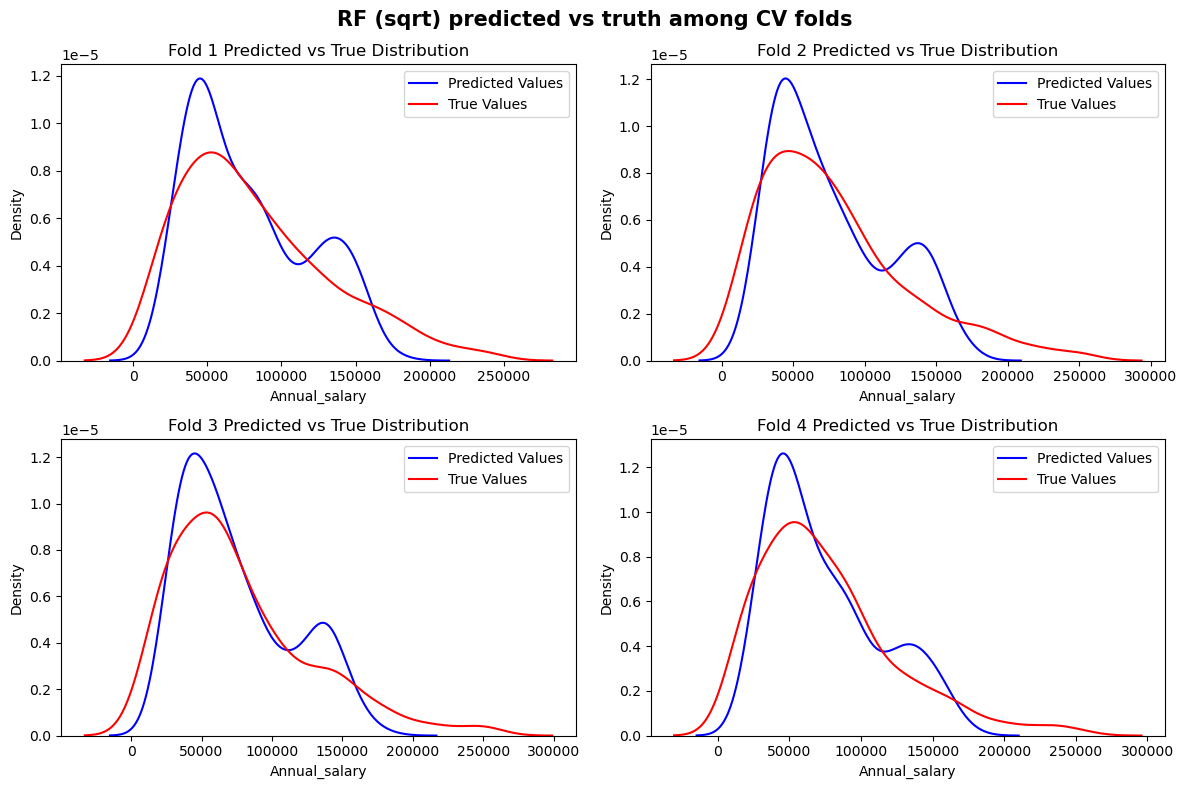

In [12]:
fold_num = 1
plt.figure(figsize=(12, 8))
for train_index, test_index in kf.split(X_train_scaled):
    
    X_fold_test = X_train_scaled.iloc[test_index]
    y_fold_true = y_train.iloc[test_index]
    
    y_fold_pred = clf.predict(X_fold_test)

    plt.subplot(2, 2, fold_num)
    sns.kdeplot(np.power(y_fold_pred,2), color='blue', label='Predicted Values')
    sns.kdeplot(np.power(y_fold_true,2), color='red', label='True Values')
    plt.title(f'Fold {fold_num} Predicted vs True Distribution')
    plt.legend()

    fold_num += 1

plt.suptitle('RF (sqrt) predicted vs truth among CV folds', weight='bold', fontsize=15)
plt.tight_layout()
plt.show()

### 3.2. Train and Test sets predictions

First, let's update model with the best parameters found in CV:

Now, we will define our metrics for train and test sets:

In [13]:
def adjusted_r2(r2, n, p):
    """Calculate adjusted R^2 given R^2, number of observations (n) and number of predictors (p)"""
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    
def metrics(model, X, y_true, inverse_transform=True):
    """
    Calculate average metrics (R^2, RMSE, Adjusted R^2) and predictions from cross-validation results
    and return them
    """
    y_pred = model.predict(X)
    if inverse_transform:
        y_pred = np.power(y_pred, 2)  
        y_true = np.power(y_true, 2) 
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = adjusted_r2(r2, X.shape[0], X.shape[1])
    
    return {'R^2': r2, 'RMSE': rmse, 'Adjusted R^2': adj_r2, 'Predictions': y_pred}

#### 3.2.1. Train/Test set results


Train set metrics:
R^2: 0.7649701782830405
RMSE: 24381.331123256725
Adjusted R^2: 0.7549364225531285


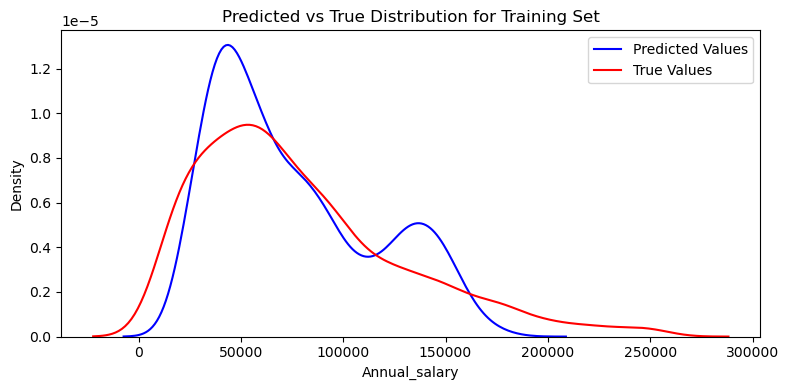

In [14]:
train_results = metrics(clf.best_estimator_, X_train_scaled, y_train)

print("\nTrain set metrics:")
for key in list(train_results.keys())[:3]:
    print(f"{key}: {train_results[key]}")

y_train_pred = clf.best_estimator_.predict(X_train_scaled)

plt.figure(figsize=(8, 4))

sns.kdeplot(np.power(y_train_pred,2), color='blue', label='Predicted Values')
sns.kdeplot(np.power(y_train,2), color='red', label='True Values')
plt.title('Predicted vs True Distribution for Training Set')
plt.legend()

plt.tight_layout()
plt.show()


Test set metrics:
R^2: 0.6489785152188796
RMSE: 29348.416214758974
Adjusted R^2: 0.5786212677246245


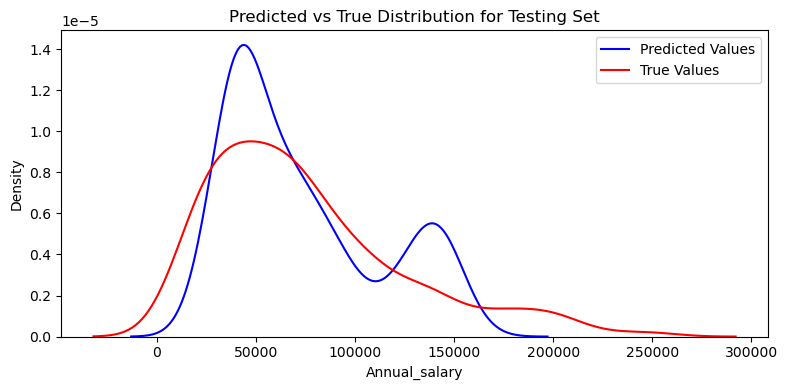

In [15]:
test_results = metrics(clf.best_estimator_, X_test_scaled, y_test)

print("\nTest set metrics:")
for key in list(test_results.keys())[:3]:
    print(f"{key}: {test_results[key]}")

y_test_pred = clf.best_estimator_.predict(X_test_scaled)

plt.figure(figsize=(8, 4))

# Plotting
sns.kdeplot(np.power(y_test_pred,2), color='blue', label='Predicted Values')
sns.kdeplot(np.power(y_test,2), color='red', label='True Values')
plt.title('Predicted vs True Distribution for Testing Set')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
y_pred_train = train_results['Predictions']
y_pred_test = test_results['Predictions']

## 4. Plotting results

### 4.1. Residuals Plot

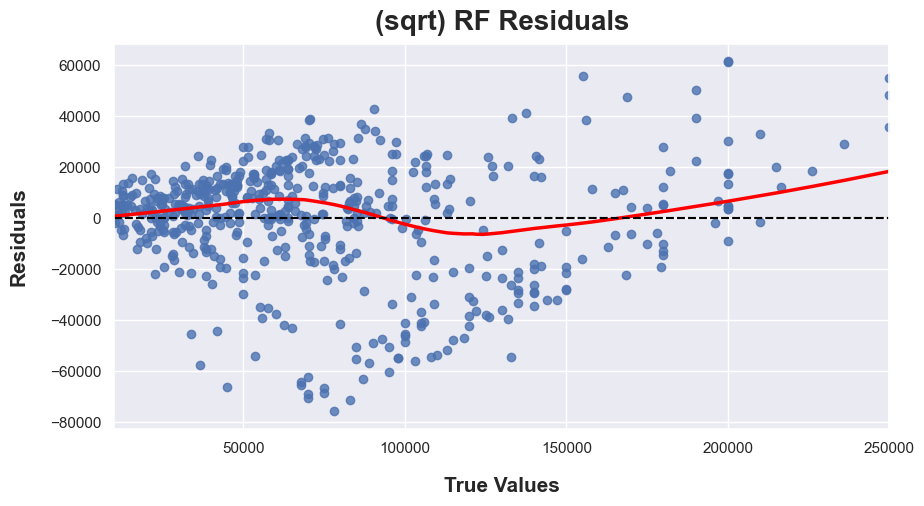

In [17]:
sns.set_theme(style='darkgrid')

residuals = np.power(y_test, 2) - y_pred_test

plt.figure(figsize=(10,5))

sns.residplot(x=np.power(y_test, 2), y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 2.5})

plt.title('(sqrt) RF Residuals', weight='bold', fontsize=20, pad=10)
plt.xlabel('True Values', weight='bold', fontsize=15, labelpad= 15)
plt.ylabel('Residuals', weight='bold', fontsize=15, labelpad= 15)
plt.axhline(y=0, color='black', linestyle='--')
plt.savefig("../../paper/models/sqrt-rf-test-residuals.pdf");

### 4.2. Test set performance

<Figure size 1000x600 with 0 Axes>

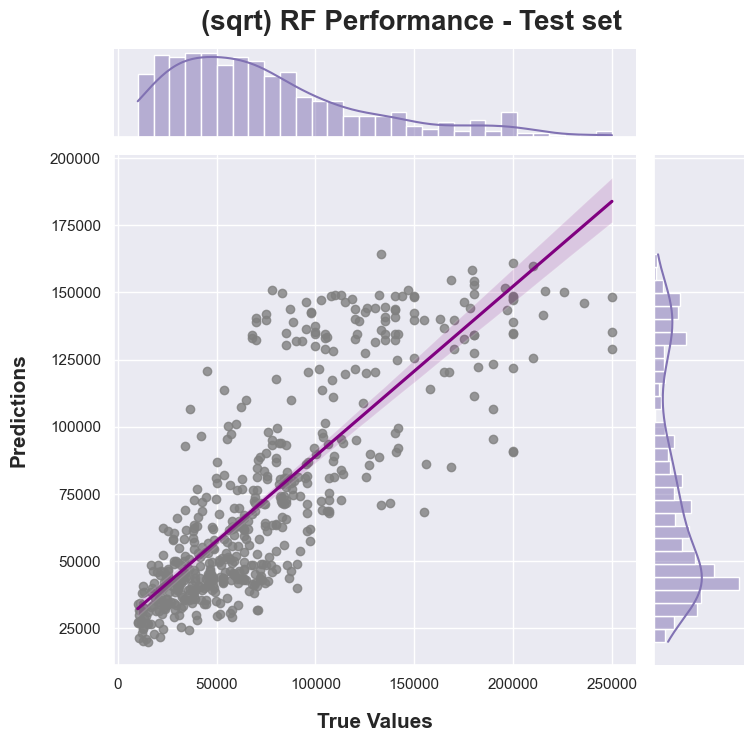

In [18]:
sns.set_theme(style='darkgrid')

plt.figure(figsize=(10, 6))

sns.jointplot(x=np.power(y_test, 2), y=y_pred_test, kind='reg', 
              joint_kws={'color':'grey', 'line_kws':{'color':'purple'}},
              marginal_kws=dict(bins=30, fill=True, color='m'), height=7)

plt.suptitle('(sqrt) RF Performance - Test set', weight='bold', y=1.03, fontsize=20)
plt.xlabel('True Values', weight='bold', labelpad=15, fontsize=15)
plt.ylabel('Predictions', weight='bold', labelpad=15, fontsize=15)

plt.savefig("../../paper/models/sqrt-rf-test-predictions.pdf");

## 6. Saving results

Saving CV results

In [19]:
df_cv_results.to_csv("../../output/sqrt-rf-cv-results.csv")

Saving train and test sets predictions

In [20]:
np.savetxt("../../output/sqrt-rf-train-predictions.csv", y_pred_train, delimiter=",")

np.savetxt("../../output/sqrt-rf-test-predictions.csv", y_pred_test, delimiter=",")

In [21]:
pd.set_option('display.max_colwidth', None)

df_cv_results[['params', 'mean_train_r2', 'mean_test_r2','mean_train_rmse', 'mean_test_rmse']]


,params,mean_train_r2,mean_test_r2,mean_train_rmse,mean_test_rmse
0,"{'bootstrap': True, 'max_depth': 26, 'max_features': 33, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 170}",0.761709,0.610936,24545.173206,31316.522758
1,"{'bootstrap': True, 'max_depth': 26, 'max_features': 39, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 480}",0.777409,0.612655,23722.403737,31248.028028
2,"{'bootstrap': True, 'max_depth': 27, 'max_features': 34, 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 280}",0.742402,0.607831,25520.175942,31439.731000
3,"{'bootstrap': True, 'max_depth': 25, 'max_features': 34, 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 641}",0.742006,0.608130,25539.846042,31427.969728
4,"{'bootstrap': True, 'max_depth': 25, 'max_features': 31, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 310}",0.739500,0.607763,25663.278741,31443.228674
5,"{'bootstrap': True, 'max_depth': 29, 'max_features': 35, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 710}",0.761071,0.614345,24577.942039,31179.035080
6,"{'bootstrap': True, 'max_depth': 29, 'max_features': 45, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 716}",0.760406,0.608857,24612.060986,31401.276606
7,"{'bootstrap': True, 'max_depth': 23, 'max_features': 45, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 634}",0.793671,0.610269,22839.397204,31345.723245
8,"{'bootstrap': True, 'max_depth': 22, 'max_features': 36, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 316}",0.757971,0.612299,24736.302453,31260.139624
9,"{'bootstrap': True, 'max_depth': 21, 'max_features': 33, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 495}",0.773606,0.611031,23924.711877,31312.068009


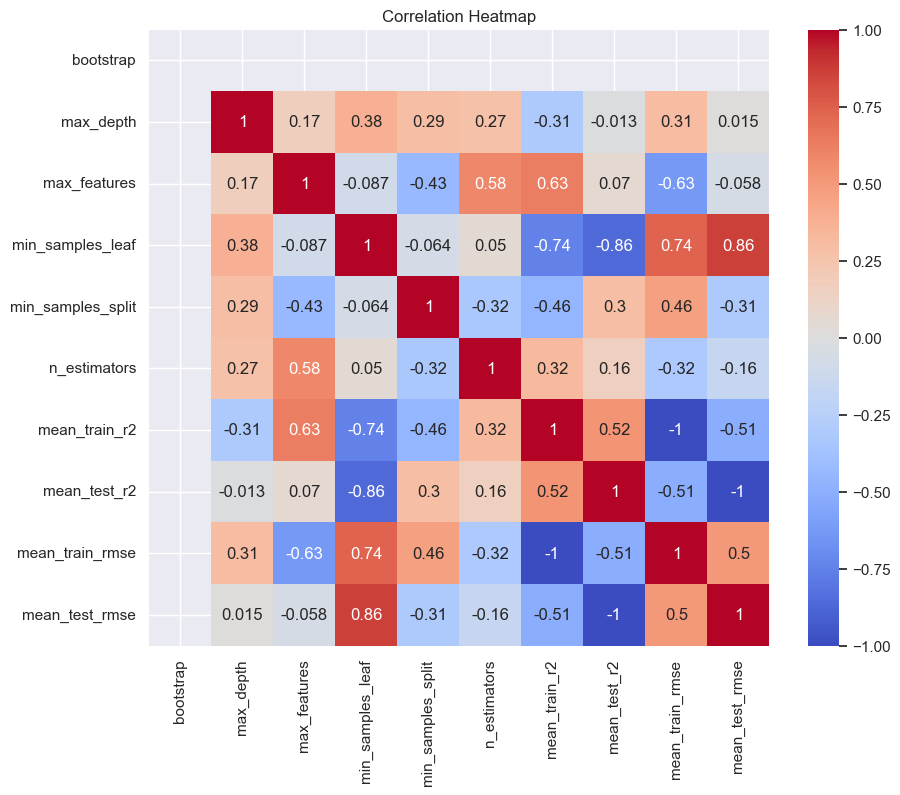

In [22]:
df_subset = df_cv_results[['params', 'mean_train_r2', 'mean_test_r2', 'mean_train_rmse', 'mean_test_rmse']]

# Extraer las características de la columna 'params' en columnas individuales
params_df = df_subset['params'].apply(pd.Series)
df_processed = pd.concat([params_df, df_subset[['mean_train_r2', 'mean_test_r2', 'mean_train_rmse', 'mean_test_rmse']]], axis=1)

# Convertir valores de 'bootstrap' a números
df_processed['bootstrap'] = df_processed['bootstrap'].astype(int)

# Calcular la correlación de Pearson
corr = df_processed.corr()

# Crear el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

In [23]:
corr

,bootstrap,max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,mean_train_r2,mean_test_r2,mean_train_rmse,mean_test_rmse
bootstrap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max_depth,NaN,1.000000,0.169804,0.381096,0.294611,0.268649,-0.306268,-0.013240,0.310681,0.014910
max_features,NaN,0.169804,1.000000,-0.086940,-0.432362,0.582372,0.625986,0.069972,-0.628361,-0.058402
min_samples_leaf,NaN,0.381096,-0.086940,1.000000,-0.063758,0.050399,-0.743738,-0.862373,0.736879,0.859892
min_samples_split,NaN,0.294611,-0.432362,-0.063758,1.000000,-0.323505,-0.456794,0.296500,0.461225,-0.305284
n_estimators,NaN,0.268649,0.582372,0.050399,-0.323505,1.000000,0.316620,0.162370,-0.317373,-0.156296
mean_train_r2,NaN,-0.306268,0.625986,-0.743738,-0.456794,0.316620,1.000000,0.524560,-0.999813,-0.514349
mean_test_r2,NaN,-0.013240,0.069972,-0.862373,0.296500,0.162370,0.524560,1.000000,-0.513425,-0.999900
mean_train_rmse,NaN,0.310681,-0.628361,0.736879,0.461225,-0.317373,-0.999813,-0.513425,1.000000,0.503142
mean_test_rmse,NaN,0.014910,-0.058402,0.859892,-0.305284,-0.156296,-0.514349,-0.999900,0.503142,1.000000
